In [26]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Using Own Encoding {-}

In [362]:
x_train = pd.read_csv('/Users/prasanth/Desktop/ece657a-1221-asg3-fashionmnist-datafiles/x_train.csv').values
x_test = pd.read_csv('/Users/prasanth/Desktop/ece657a-1221-asg3-fashionmnist-datafiles/x_test.csv').values

In [363]:
x_train = x_train.reshape((-1, 28, 28, 1)) 
x_test = x_test.reshape((-1, 28, 28, 1))

In [364]:
y_train = pd.read_csv('/Users/prasanth/Desktop/ece657a-1221-asg3-fashionmnist-datafiles/y_train.csv').values
y_test = pd.read_csv('/Users/prasanth/Desktop/ece657a-1221-asg3-fashionmnist-datafiles/y_test.csv').values

In [365]:
num_classes = 5
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

In [370]:
#Own Model
own_model = Sequential()
own_model.add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1)))
own_model.add(Dropout(0.2))
own_model.add(BatchNormalization())
own_model.add(MaxPooling2D())
own_model.add(Conv2D(128,kernel_size=5,activation='relu'))
own_model.add(Dropout(0.2))
own_model.add(BatchNormalization()) 
own_model.add(MaxPooling2D())
own_model.add(Flatten())
own_model.add(Dense(64, activation='relu'))
own_model.add(Dropout(0.2))
own_model.add(Dense(5, activation='softmax'))
own_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])




In [371]:
start_time2 = time.time()
own_model_result = own_model.fit(x_train,Y_train, batch_size=128, epochs = 19, validation_split = 0.1, verbose = 0)
end_time2 = time.time()
run_time2 = end_time2 - start_time2
print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format('Own Model',19,max(own_model_result.history['accuracy']),max(own_model_result.history['val_accuracy']) ))

CNN Own Model: Epochs=19, Train accuracy=0.97198, Validation accuracy=0.94683


In [372]:
encoded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928

Using the Dense Layer consisting of 64 units as the intermediate layer to retrieve the encodings and use it as features for clustering and visualization to predict the mystery labels

In [373]:
#encoding
encoded_model = keras.Model(own_model.layers[0].input, own_model.layers[9].output)

In [374]:
X_encoded = encoded_model(x_test)

### Visualizing the encodings with PCA (n=2) {-}

In [375]:
pca = PCA(n_components = 2, random_state = 54)
X_pca = pca.fit_transform(X_encoded)


In [376]:
print(y_test.ravel())

[4 2 2 ... 3 2 1]


[]

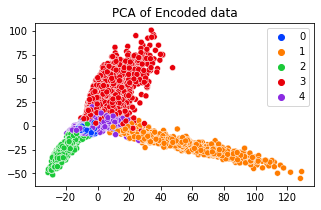

In [449]:
plt.figure(figsize = (5,3))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue=y_test.ravel(), palette="bright")
plt.title('PCA of Encoded data')

plt.plot()

Visualizing the encoding from PCA, we can observe that
- Class 1, 2 and 3 are distinctive from the rest of the classes, with slight overlap in centre.
- Class 0 and 4 are highly correlated and overlapping with other classes.

Hence, representing the encodings using PCA with 2 dimensions does not provide better representation for clustering the given dataset.

### DBSCAN & K-Means Clustering {-}

#### DBSCAN {-}



Identifying the best value of Epsilon in DBSCAN using the silhouette score

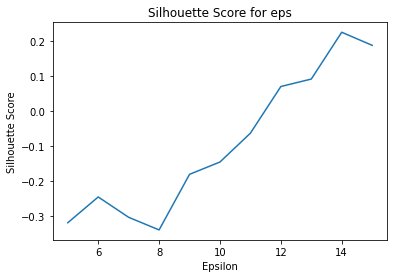

In [407]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = range(5, 16, 1)
scores = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(X_encoded)
    score = silhouette_score(X_encoded, labels)
    scores.append(score)
    
plt.plot(eps_values, scores)
plt.title('Silhouette Score for eps')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.show()

Using epsilon = 14, as it provides the max silhouette score before drop.

In [406]:
clustering = DBSCAN(eps=14, min_samples=28).fit(X_encoded)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([2671, 1782, 4587,  828,  104,   28]))

[]

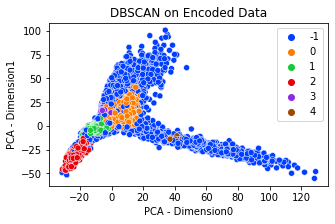

In [450]:
plt.figure(figsize = (5,3))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clustering.labels_, palette="bright")
plt.title('DBSCAN on Encoded Data')
plt.xlabel('PCA - Dimension0')
plt.ylabel('PCA - Dimension1')
plt.plot()


From DBSCAN plot, we can visualize that most of the datapoints are classified as outliers/noise. Also, there is no significant separation between classes and outliers as all classes overlap the outlier space. 
Hence, DBSCAN does not provide good classification of the data.

#### K-means Clustering {-}

In [411]:
kmeans = KMeans(n_clusters = 5, random_state = 54).fit(X_encoded)

[]

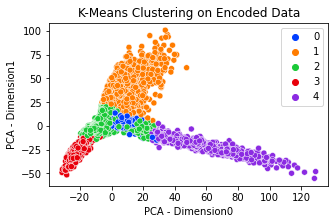

In [451]:
plt.figure(figsize = (5,3))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = kmeans.labels_, palette = 'bright')
plt.title('K-Means Clustering on Encoded Data')
plt.xlabel('PCA - Dimension0')
plt.ylabel('PCA - Dimension1')
plt.plot()

K-means provides the better classification when compared to DBSCAN.
There is overlap between classes 0 and 2. 

### TSNE on the Encoded Data {-}

In [413]:
X_tsne = TSNE(n_components = 2, random_state = 54).fit_transform(X_encoded)

[]

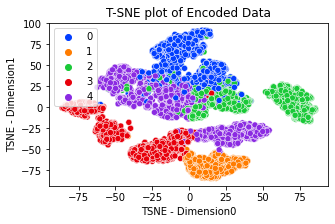

In [452]:
# T-SNE visualization
plt.figure(figsize = (5,3))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_test.ravel(), palette="bright")
plt.title('T-SNE plot of Encoded Data')
plt.xlabel('TSNE - Dimension0')
plt.ylabel('TSNE - Dimension1')
plt.plot()

The resulting clusters from TSNE does not match with the actual classification as observed from the plot. There are multiple clusters for all classes except 0 and 1.
Also, the clustering is irregular as we can observe certain datapoints of classes 0, 2 and 3 far away from their respective clusters.

### Predicting the Mystery Labels {-}


#### Using the labels derived from K-Means Clustering {-}



We are making use of the labels classified using K-Means rather than DBSCAN as it provides a better classification because the clustering result from DBSCAN is insignificant, plot contains multiple clusters for some classes.

In [454]:
x_test_mystery = x_test
y_test_mystery = kmeans.labels_

x_test_mystery = x_test_mystery.reshape((-1, 28, 28))

print("x_test_mystery shape:", x_test_mystery.shape)
#print("y_test_subset shape:", y_test_subset.shape)

x_class_0 = np.array(x_test_mystery[y_test_mystery == 0])
x_class_1 = np.array(x_test_mystery[y_test_mystery == 1])
x_class_2 = np.array(x_test_mystery[y_test_mystery == 2])
x_class_3 = np.array(x_test_mystery[y_test_mystery == 3])
x_class_4 = np.array(x_test_mystery[y_test_mystery == 4])

x_test_mystery shape: (10000, 28, 28)


Visualizing Images of Classification using K-Means

 Class 0 Images

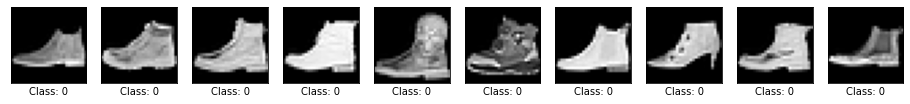

In [456]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_0[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 0')
#fig.suptitle('Class 0 Images')
plt.show()


Class 1 Images

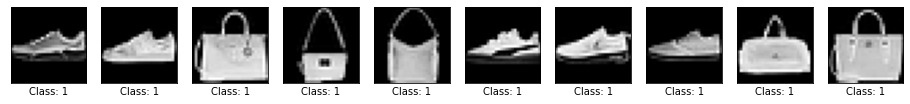

In [457]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_1[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 1')

#fig.suptitle('Class 1 Images')
plt.show()



Class 2 Images

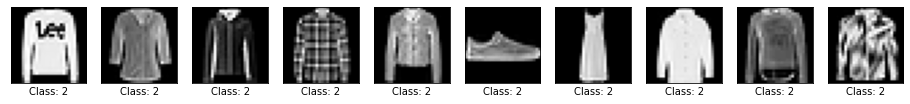

In [458]:
fig, axis = plt.subplots(1,10,figsize = (16,4))#nrows=2, ncols=10, figsize=(12,4))
for i, ax in enumerate(axis.ravel()):
    ax.imshow(x_class_2[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 2')

#fig.suptitle('Class 2 Images')
plt.show()




Class 3 Images

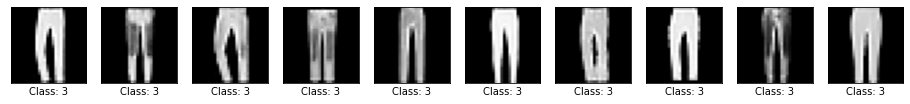

In [459]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i, ax in enumerate(axis.ravel()):
    ax.imshow(x_class_3[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 3')

#fig.suptitle('Class 3 Images')
plt.show()




Class 4 Images

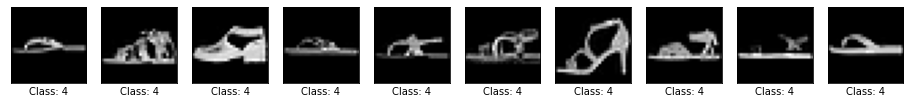

In [461]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i, ax in enumerate(axis.ravel()):
    ax.imshow(x_class_4[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 4')

#fig.suptitle('Class 4 Images')
plt.show()



In [421]:
x_class_0 = np.mean(x_test_mystery[y_test_mystery == 0], axis=0)
x_class_1 = np.mean(x_test_mystery[y_test_mystery == 1], axis=0)
x_class_2 = np.mean(x_test_mystery[y_test_mystery == 2], axis=0)
x_class_3 = np.mean(x_test_mystery[y_test_mystery == 3], axis=0)
x_class_4 = np.mean(x_test_mystery[y_test_mystery == 4], axis=0)

x_class = np.array([x_class_0, x_class_1, x_class_2, x_class_3, x_class_4])
x_class.shape


(5, 28, 28)

The Average Images of each Class

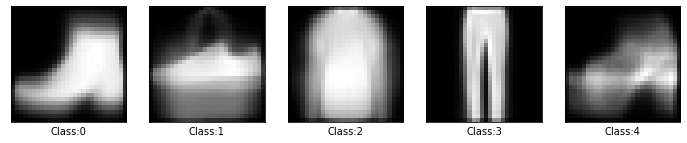

In [462]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
for i in range(5):
    ax[i].imshow(x_class[i], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('Class:'+ str(i))

#fig.suptitle('The Average Images of each Class')
plt.show()

##### Mystery mappings for Kmeans clustering are: {-}

- Class 0: Ankle Boot
- Class 1: Sneaker, Bag
- Class 2: T-shirt/Top, Shirt, Dress, Pullover, Coat
- Class 3: Trouser
- Class 4: Sandal

It can be observed that class 2 has some misclassified elements from class 1. This can be also seen in the k-means clustering plot displayed above.

#### Predicting Mystery Labels using given Test Dataset {-}



In [291]:
x_test_mystery1 = x_test
y_test_mystery1 = y_test.flatten()

x_test_mystery1 = x_test_mystery1.reshape((-1, 28, 28))

print("x_test_mystery shape:", x_test_mystery1.shape)
print("y_test_subset shape:", y_test_mystery1.shape)

x_class_0_t = np.array(x_test_mystery1[y_test_mystery1 == 0])
x_class_1_t = np.array(x_test_mystery1[y_test_mystery1 == 1])
x_class_2_t = np.array(x_test_mystery1[y_test_mystery1 == 2])
x_class_3_t = np.array(x_test_mystery1[y_test_mystery1 == 3])
x_class_4_t = np.array(x_test_mystery1[y_test_mystery1 == 4])

x_test_mystery shape: (10000, 28, 28)
y_test_subset shape: (10000,)


Class 0 Images

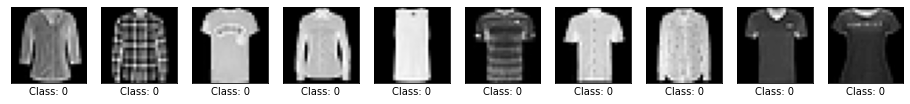

In [463]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_0_t[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 0')

#fig.suptitle('Class 0 Images')
plt.show()

Class 1 Images

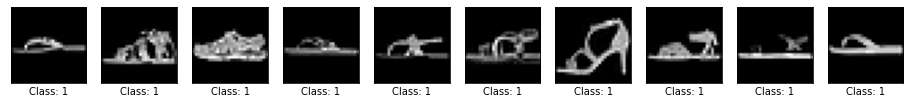

In [465]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_1_t[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 1')

#fig.suptitle('Class 1 Images')
plt.show()

Class 2 Images

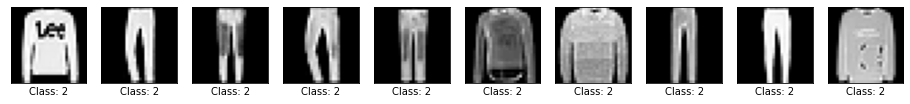

In [466]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_2_t[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 2')

#fig.suptitle('Class 2 Images')
plt.show()

Class 3 Images

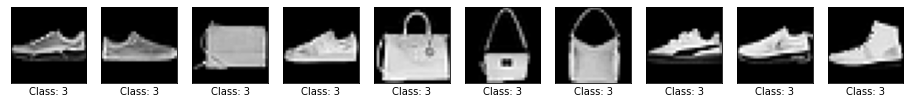

In [468]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_3_t[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 3')

#fig.suptitle('Class 3 Images')
plt.show()

Class 4 Images

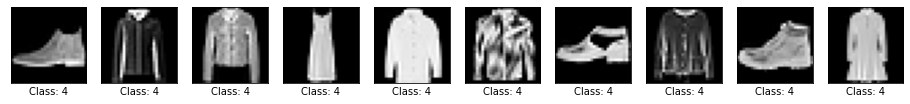

In [469]:
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
for i,ax in enumerate(axis.ravel()):
    ax.imshow(x_class_4_t[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Class: 4')

#fig.suptitle('Class 4 Images')
plt.show()

In [198]:
x_class_0_t = np.mean(x_test_mystery1[y_test_mystery1 == 0], axis=0)
x_class_1_t = np.mean(x_test_mystery1[y_test_mystery1 == 1], axis=0)
x_class_2_t = np.mean(x_test_mystery1[y_test_mystery1 == 2], axis=0)
x_class_3_t = np.mean(x_test_mystery1[y_test_mystery1 == 3], axis=0)
x_class_4_t = np.mean(x_test_mystery1[y_test_mystery1 == 4], axis=0)

x_class_t = np.array([x_class_0_t, x_class_1_t, x_class_2_t, x_class_3_t, x_class_4_t])
x_class_t.shape



(5, 28, 28)

Average Images of Each Class

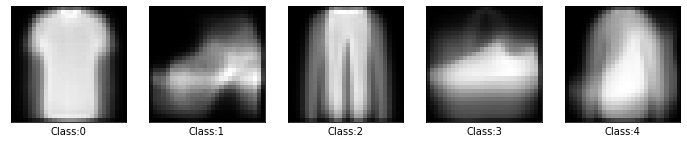

In [470]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
for i in range(5):
    ax[i].imshow(x_class_t[i], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('Class:'+ str(i))

#fig.suptitle('Average Images of each Class')
plt.show()


##### Mystery mapping for original test set are {-}

- Class 0: Shirt, T-Shirt/Top
- Class 1: Sandal
- Class 2: Trouser, Pullover
- Class 3: Sneaker, Bag
- Class 4: Dress, Coat, Ankle boot

All classes contain multiple categories in it except for class 1 which only contains Sandal.

In [423]:
kmeans_df = pd.DataFrame(y_test_mystery, columns = ['Class'])
test_df = pd.DataFrame(y_test_mystery1, columns = ['Class'])

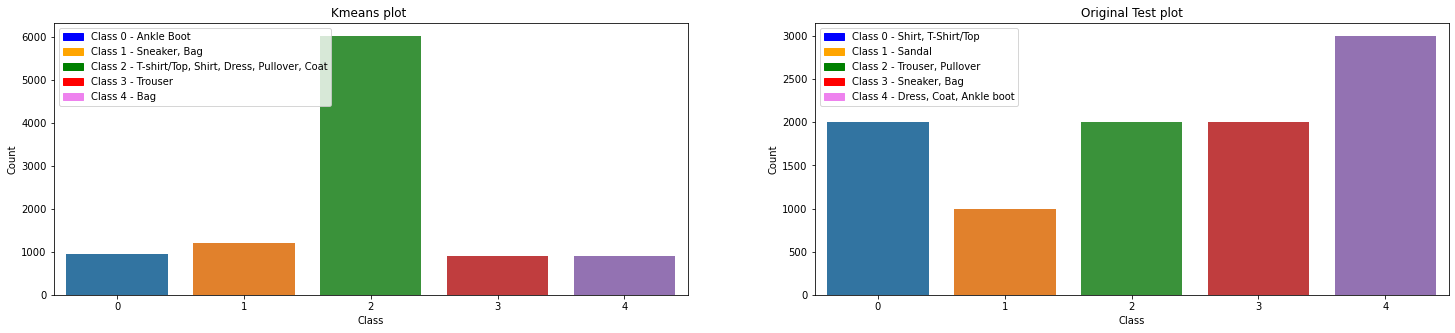

In [472]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
labels = ["Class 0 - Ankle Boot","Class 1 - Sneaker, Bag",
          "Class 2 - T-shirt/Top, Shirt, Dress, Pullover, Coat",
          "Class 3 - Trouser","Class 4 - Bag"]
colors = {'Class 0 - Ankle Boot':'blue', 'Class 1 - Sneaker, Bag':'orange',
          'Class 2 - T-shirt/Top, Shirt, Dress, Pullover, Coat':'green', 
          'Class 3 - Trouser':'red','Class 4 - Bag':'violet'} 
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
sns.countplot(ax=ax[0], x ='Class', data = kmeans_df)
ax[0].set_title('Kmeans plot ')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].legend(handles, labels , loc = 'upper left')

labels1 = ["Class 0 - Shirt, T-Shirt/Top",
"Class 1 - Sandal", "Class 2 - Trouser, Pullover", "Class 3 - Sneaker, Bag", "Class 4 - Dress, Coat, Ankle boot"]
colors1 = {'Class 0 - Shirt, T-Shirt/Top':'blue', 
           'Class 1 - Sandal':'orange',
          'Class 2 - Trouser, Pullover':'green', 
          'Class 3 - Sneaker, Bag':'red','Class 4 - Dress, Coat, Ankle boot':'violet'} 
handles1 = [plt.Rectangle((0,0),1,1, color=colors1[label]) for label in labels1]
sns.countplot(ax=ax[1], x ='Class', data = test_df)
ax[1].set_title('Original Test plot')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
ax[1].legend(handles1, labels1 , loc = 'upper left')

The number of elements in classes are a bit balanced in the given raw dataset. When using K-means, the classes are all segmented based on the features with similar elements being categorised into each class. For instance, all clothing such as T-shirt/Top, Shirt, Dress, Pullover, Coat are categorised as a single class.

Ankle Boot, Trouser and Bag are all categorised as individual classes in K-means.

Sneaker and Bag are categorised together just as given in the Raw Test dataset.

### Using the Feature Encodings from Auto Encoder {-}

Autoencoder is used here as an alternative to PCA for dimensional reduction, the encoded data derived from the intermediate layer is passed as an input to the autoencoder and dimensionality is then reduced to represent the encoding features.

We compare the classification and accuracy achieved using PCA and Autoencoder Dimensional Reductionality to find the one with best performance.

In [207]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape

encoded_dimension = 2

ncol = tf.shape(X_encoded)[1]

input_dim = Input(shape = (ncol,))

encoded1 = Dense(32, activation = 'relu')(input_dim)
encoded2 = Dense(16, activation = 'relu')(encoded1)
encoded3 = Dense(encoded_dimension, activation = 'relu')(encoded2)


decoded1 = Dense(16, activation = 'relu')(encoded3)
decoded2 = Dense(32, activation = 'relu')(decoded1)
decoded3 = Dense(ncol, activation = 'relu')(decoded2)
                  
                            
autoencoder = Model(inputs = input_dim, outputs = decoded3)
                  
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')


Model Summary of the Auto Encoder

In [208]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 2)                 34        
                                                                 
 dense_11 (Dense)            (None, 16)                48        
                                                                 
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dense_13 (Dense)            (None, 64)                2112

The representation of the Encoded Data from Intermediate Layer in CNN model is passed as an input and its best representation is extracted from the mid Dense layer which contains the representation of the features in 2 dimensional space.

In [426]:
autoencoder.fit(X_encoded, X_encoded, epochs = 30, batch_size = 32, shuffle = False, validation_split = 0.1, verbose = 1)

Epoch 1/30
282/282 [==============================] - 2s 7ms/step - loss: 7.4799 - val_loss: 6.0911
Epoch 2/30
282/282 [==============================] - 1s 4ms/step - loss: 5.9710 - val_loss: 5.8102
Epoch 3/30
282/282 [==============================] - 1s 4ms/step - loss: 6.0497 - val_loss: 5.4733
Epoch 4/30
282/282 [==============================] - 1s 4ms/step - loss: 7.1737 - val_loss: 6.2806
Epoch 5/30
282/282 [==============================] - 1s 3ms/step - loss: 6.7679 - val_loss: 7.2437
Epoch 6/30
282/282 [==============================] - 1s 3ms/step - loss: 6.8240 - val_loss: 6.2249
Epoch 7/30
282/282 [==============================] - 1s 3ms/step - loss: 6.4440 - val_loss: 6.1109
Epoch 8/30
282/282 [==============================] - 1s 3ms/step - loss: 6.3307 - val_loss: 5.9586
Epoch 9/30
282/282 [==============================] - 1s 3ms/step - loss: 6.2107 - val_loss: 5.8591
Epoch 10/30
282/282 [==============================] - 1s 3ms/step - loss: 5.8415 - val_loss: 5.1144

In [428]:
autoencoder.fit(X_encoded, X_encoded, epochs = 28, batch_size = 32, shuffle = False, validation_split = 0.1, verbose = 1)

Epoch 1/28
282/282 [==============================] - 3s 9ms/step - loss: 7.0304 - val_loss: 7.0138
Epoch 2/28
282/282 [==============================] - 2s 8ms/step - loss: 7.0187 - val_loss: 7.0808
Epoch 3/28
282/282 [==============================] - 2s 7ms/step - loss: 7.0403 - val_loss: 7.0872
Epoch 4/28
282/282 [==============================] - 2s 7ms/step - loss: 7.2349 - val_loss: 7.2025
Epoch 5/28
282/282 [==============================] - 2s 7ms/step - loss: 7.1157 - val_loss: 7.1298
Epoch 6/28
282/282 [==============================] - 2s 7ms/step - loss: 7.1259 - val_loss: 7.1311
Epoch 7/28
282/282 [==============================] - 2s 7ms/step - loss: 7.1771 - val_loss: 7.2066
Epoch 8/28
282/282 [==============================] - 2s 7ms/step - loss: 7.1902 - val_loss: 7.2191
Epoch 9/28
282/282 [==============================] - 2s 7ms/step - loss: 7.1369 - val_loss: 7.1258
Epoch 10/28
282/282 [==============================] - 2s 8ms/step - loss: 7.0640 - val_loss: 7.1115

In [429]:
encoder = Model(inputs = input_dim, outputs = encoded3)

In [430]:
X_autoencoded = pd.DataFrame(encoder.predict(X_encoded))

313/313 [==============================] - 2s 5ms/step


In [431]:
X_autoencoded.head()

,0,1
0,131.608963,50.741726
1,28.553507,50.362892
2,37.549011,117.003746
3,46.117317,134.212875
4,0.000000,0.000000


#### Scatter plot of the Autoencoded Features {-}

[]

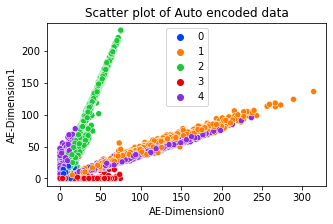

In [473]:
plt.figure(figsize = (5,3))
sns.scatterplot(x = X_autoencoded[0], y = X_autoencoded[1], hue=y_test.ravel(), palette="bright")
plt.title('Scatter plot of Auto encoded data')
plt.xlabel('AE-Dimension0')
plt.ylabel('AE-Dimension1')
plt.plot()

Visualizing the encoding from Autoencoder, we can observe that
- Class 2 and 3 are distinctive from rest of the classes, with slight overlap in centre.
- Class 1 and 4 are correlated and overlapping with each other.
- Class 0 overaps with all other classes.

#### Visualizing the K-Means labels on Autoencoded Data {-}

In [433]:
kmeans = KMeans(n_clusters = 5, random_state = 54).fit(X_encoded)

[]

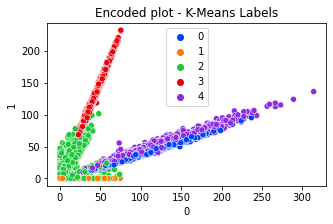

In [474]:
plt.figure(figsize = (5,3))
sns.scatterplot(x = X_autoencoded[0], y = X_autoencoded[1], hue = kmeans.labels_, palette = 'bright')
plt.title('Encoded plot - K-Means Labels')
plt.plot()

K-means provides better classification than the test labels. Using K-Means, there is overlap between classes 0 and 4, classes 1 and 2. Other classes are well classified compared to test labels.

In [435]:
x_test_mystery_ae = x_test
y_test_mystery_ae = kmeans.labels_

x_test_mystery_ae = x_test_mystery_ae.reshape((-1, 28, 28))

print("x_test_mystery shape:", x_test_mystery_ae.shape)
#print("y_test_subset shape:", y_test_subset.shape)

x_class_0_ae = np.array(x_test_mystery_ae[y_test_mystery_ae == 0])
x_class_1_ae = np.array(x_test_mystery_ae[y_test_mystery_ae == 1])
x_class_2_ae = np.array(x_test_mystery_ae[y_test_mystery_ae == 2])
x_class_3_ae = np.array(x_test_mystery_ae[y_test_mystery_ae == 3])
x_class_4_ae = np.array(x_test_mystery_ae[y_test_mystery_ae == 4])

x_test_mystery shape: (10000, 28, 28)


#### KNN Accuracy Comparison for PCA and Autoencoder {-}

In [436]:
#Training KNN using PCA & Autoencoder Features

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from statistics import mean

In [443]:
knn = KNeighborsClassifier(n_neighbors = 25)
# X,y will automatically devided by 5 folder, the scoring I will still use the accuracy
score_pca = cross_val_score(knn, X_pca, y_test.ravel(), cv=5, scoring='accuracy')
score_ae = cross_val_score(knn, X_autoencoded, y_test.ravel(), cv=5, scoring='accuracy')

In [444]:
print('Accuracy Score from PCA - {:.2f}%'.format(mean(score_pca*100)))
print('Accuracy Score from AE - {:.2f}%'.format(mean(score_ae*100)))

Accuracy Score from PCA - 75.73%
Accuracy Score from AE - 79.55%


Better accuracy is achieved using Autoencoder than PCA.